In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU111

	Software version: 0.2.181
	Firmware timestamp: Wed Aug 16 13:39:03 2023

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 0, blk 0, 32-bit DDS, fabric=384.000 MHz, f_dds=6144.000 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 0, blk 1, 32-bit DDS, fabric=384.000 MHz, f_dds=6144.000 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 0, blk 2, 32-bit DDS, fabric=384.000 MHz, f_dds=6144.000 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 1, blk 0, 32-bit DDS, fabric=384.000 MHz, f_dds=6144.000 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 1, blk 1, 32-bit DDS, fabric=384.000 MHz, f_dds=6144.000 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC ti

### Hardware Configuration

You should cable the board in loopback, connecting one DAC to one ADC. You can set appropriate generator and readout numbers in the cell below, which will be used in `res_ch` and `ro_chs` entries in the program dictionaries below.

For example, for a ZCU111 you might connect DAC229_T1_CH3 to ADC224_T0_CH0 (these are the labels on the XM500 balun board). The DAC and ADC lists tell you that these are DAC tile 1, block 3, and ADC tile 0, block 0. The generator and readout lists tell you that these are driven by generator 6 and readout 0, and your QICK programs will reference those IDs.

In [3]:
GEN_CH = 6
RO_CH = 0

## Things to know when writing programs

### How to avoid timing problems
Timed instructions are executed in two steps: first when the control core of the tProcessor pushes the instruction into the timed queue, and second when the instruction pops off the timed queue. This is described in more detail [here](https://qick-docs.readthedocs.io/en/latest/cheatsheet.html#timing).
* The control core executes all instructions in order and (except wait/waiti) as quickly as possible. If you have a non-timed instruction with external effects, it will generally execute before the timed instructions before and after it. Specifically, programs (like the [`AveragerProgram`](https://qick-docs.readthedocs.io/en/latest/_modules/qick/averager_program.html#AveragerProgram.make_program) framework we're using here) typically use memwi to update a data counter, and then read that counter to know how many data samples to get from the buffers - if the memwi happens before the readout is triggered or completed, you will read invalid data.
* If the instruction is pushed later than the specified time, it will execute later than specified - this can lead to variations in the relative timing of pulses and readout windows. You are responsible for keeping the control core running ahead of the instruction times.

Things you should do in your programs:
* Your initialization should contain a synci instruction which gives the tProcessor time to get ahead of the clock.
* Put a [`sync_all()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.asm_v1.html#qick.asm_v1.QickProgram.sync_all) somewhere in your loop body, probably at the end. This ensures that you don't have pulses or readouts that exceed the loop length.
* Put a waiti instruction after the last readout in your loop body, to make sure the tProcessor doesn't prematurely update the data counter.
* Follow the waiti with a sync that exceeds the waiti, to allow the tProcessor to get ahead of the clock.

The last three points are automatically addressed if the last timed instruction in your loop body is a [`measure()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.asm_v1.html#qick.asm_v1.QickProgram.measure) instruction that specifies `wait=True` and a nonzero `syncdelay`.

### How to ensure frequency matching
DACs and ADCs have different frequency units, and the frequencies used in the two systems must be exactly equal. If they are not, there will be a small difference between the upconversion and downconversion frequencies - this will manifest as a sliding phase, and so you will not see a consistent phase between acquisitions.

There are two ways to ensure frequency matching:
* When converting a frequency to an integer value (often with [`freq2reg()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.qick_asm.html#qick.qick_asm.QickConfig.freq2reg) or [`declare_readout()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.qick_asm.html#qick.qick_asm.AbsQickProgram.declare_readout)), specify not only the channel you are configuring, but the channel you want to be frequency-matched to.
* Before doing any conversion, round the frequency to the closest frequency that is valid on both channels using [`soccfg.adcfreq(f, gen_ch, ro_ch)`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.qick_asm.html#qick.qick_asm.QickConfig.adcfreq).

Frequency-matching makes your frequency resolution worse, since the smallest possible frequency step is now the LCM of the two channels' frequency steps. Usually this doesn't matter - O(10 Hz) resolution is ample for most applications - but you can disable frequency-matching by specifying None as the other channel.

You may have a DAC channel that does not itself drive any ADC channels, but needs to be phase-locked to a DAC channel that does. In this case you will want to frequency-match both DAC channels to that ADC, otherwise you will have a sliding phase between the two DAC channels.

Since all DAC and ADC channels are the same in the standard QICK firmware, it's OK to just use ch 0 for the matched channel. But it's a good habit to do this consistently correctly, and that is the approach here.

### Clocks and durations
Time durations are generally specified in units of clock cycles. The relevant clocks are the tProcessor clock and the fabric clocks of the DACs and ADCs. In general these can all be different (and can even vary among DACs or ADCs).

For convenience, the [`us2cycles()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.qick_asm.html#qick.qick_asm.QickConfig.us2cycles) and [`cycles2us()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.qick_asm.html#qick.qick_asm.QickConfig.cycles2us) methods will convert between floating-point times and integer cycles. You should be careful to specify which clock you are using, and set the appropriate parameter in `us2cycles()`:
* Pulse parameters (the `length` parameter to [`set_pulse_registers()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.asm_v1.html#qick.asm_v1.QickProgram.set_pulse_registers), the `length` and `sigma` parameters to `add_gauss`) use the DAC clock and you should specify `gen_ch`.
* Readout parameters (the `length` parameter to [`declare_readout()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.qick_asm.html#qick.qick_asm.AbsQickProgram.declare_readout)) use the ADC clock and you should specify `ro_ch`.
* All other values will use the tProc clock. This includes sync and wait commands, and any sort of delay (`t`, `adc_trig_offset`). Don't use a channel ID parameter.

### How to play pulses
There are three steps to playing a pulse:

#### Loading a waveform
(You skip this step for rectangular "const" pulses, which have no envelope.)

Each signal generator has an internal waveform memory, which stores the I/Q data for the pulse envelope. Multiple waveforms can be stored in the same signal generator, and a single waveform can be used for different pulses (e.g. a Gaussian waveform can be used for Gaussian pulses and the ramp-up/ramp-down of flat-top pulses with different flat-top duration, each with its own gain and carrier frequency).

[`add_pulse(ch, name, idata, qdata)`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.qick_asm.html#qick.qick_asm.AbsQickProgram.add_pulse) writes an arbitrary waveform to the specified channel's waveform memory. 
[`add_gauss(ch, name, length, sigma)`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.qick_asm.html#qick.qick_asm.AbsQickProgram.add_gauss), [`add_triangle(ch, name, length)`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.qick_asm.html#qick.qick_asm.AbsQickProgram.add_triangle), and [`add_DRAG(ch, name, length, sigma, delta, alpha)`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.qick_asm.html#qick.qick_asm.AbsQickProgram.add_DRAG) write commonly-used standard pulse waveforms, with duration units of fabric clock cycles. The name is used in the next step.

#### Setting registers
There are a lot of parameters that need to be specified when playing a pulse - more than can be specified inline in a tProcessor instruction. So all the parameters must be written to registers first, and when we fire the pulse we just tell the tProcessor which registers to read.

[`set_pulse_registers()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.asm_v1.html#qick.asm_v1.QickProgram.set_pulse_registers) writes the settings for a pulse to registers. All arguments to this method must be integers in the native units of the signal generator. This can happen immediately before you fire the pulse, but if a signal generator is only used for one type of pulse you will save time for the tProcessor by setting registers in initialization, before the program loop. If you have some parameters that change from pulse to pulse, and some that never change, you can write the fixed parameters in initialization using [`default_pulse_registers()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.asm_v1.html#qick.asm_v1.QickProgram.default_pulse_registers) and the varying parameters in the body with `set_pulse_registers()`.

If you want to modify pulse parameters on the fly (for example, you might want to sweep the frequency of the qubit drive pulse), you will set the registers in two steps (you can see an example in the demo 02_Sweeping_variables):
* First, use set_pulse_registers() to write initial values for all parameters. You could do this in initialization, or right before the following step.
* Second, overwrite the register(s) you want to update. You need to get the page and address of the register using [`ch_page(ch)`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.asm_v1.html#qick.asm_v1.QickProgram.ch_page) and [`sreg(ch, name)`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.asm_v1.html#qick.asm_v1.QickProgram.sreg). Then you can use assembly instructions to change the value of that register.

#### Firing the pulse
[`pulse(ch, t)`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.asm_v1.html#qick.asm_v1.QickProgram.pulse) fires a pulse on the specified channel at the specified time, using whatever values are loaded in the registers.

Often you will want to trigger the readout at the same time: [`measure()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.asm_v1.html#qick.asm_v1.QickProgram.measure) is a wrapper around [`trigger()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.asm_v1.html#qick.asm_v1.QickProgram.trigger) and `pulse()`, and that's what is used in this demo.

In [3]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
        # equivalent to the following:
#         self.trigger(adcs=self.ro_chs,
#                      pins=[0], 
#                      adc_trig_offset=self.cfg["adc_trig_offset"])
#         self.pulse(ch=self.cfg["res_ch"])
#         self.wait_all()
#         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

### Send/receive a pulse with <code> pulse_style </code> = <code> const </code>

In [4]:
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

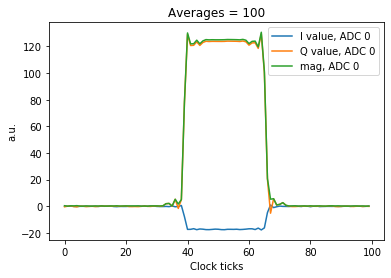

In [5]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

### Rep-to-rep consistency
In this notebook we mostly use decimated readout (we acquire a full waveform, not just a single accumulated value). To avoid exhausting the waveform buffer, we usually run with reps=1 (the tProcessor program only fires+reads one pulse, and we run the program `soft_avgs` times).

However, it's important to check that if you run a tProcessor loop with reps>1, the pulse looks the same in each iteration of the loop. So let's do a decimated readout with multiple reps; the 1024-sample buffer will allow for 10 reps of 100 samples each.

Try changing the relax_delay to 0. You will see that the first rep appears in the same place, but the others are delayed by a bit because the tProcessor didn't have enough time between waiting for the measurement in one rep and firing the pulse in the next rep.

  0%|          | 0/100 [00:00<?, ?it/s]

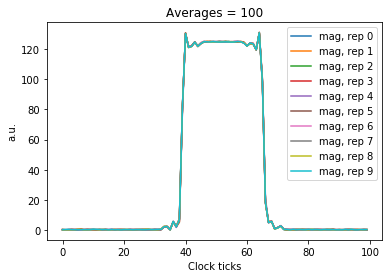

In [6]:
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":10, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)

plt.figure(1)
for ii, iq in enumerate(iq_list[0]):
#     plt.plot(iq[0], label="I value, rep %d"%(ii))
#     plt.plot(iq[1], label="Q value, rep %d"%(ii))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, rep %d"%(ii))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();


### Multiple triggers
You can send multiple triggers inside a loop. The output data arrays will gain a dimension, corresponding to the trigger number.

Let's check the rep-to-rep consistency as well as the consistency between the first and second trigger.

  0%|          | 0/100 [00:00<?, ?it/s]

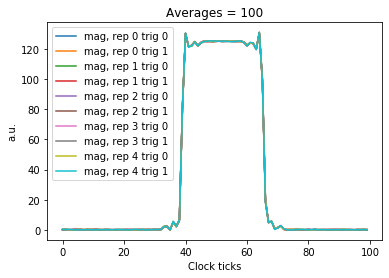

In [7]:
class DoubleTriggerProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the same pulse+trigger twice, with 100 tProc clock ticks in between
        # with the first ADC trigger, pulse PMOD0_0 for a scope trigger
        # after the second pulse, pause the tProc until readout is done
        # and increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     syncdelay=100)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":5, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages
       }

prog = DoubleTriggerProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc)

plt.figure(1)
for rep in range(config['reps']):
    for trig in range(2):
        plt.plot(np.abs(iq_list[0][rep][trig][0]+1j*iq_list[0][rep][trig][1]), label="mag, rep %d trig %d"%(rep, trig))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

### Multiple pulses

Here's an example of playing multiple pulses from the same generator, with a 90-degree shift in the carrier phase between the two pulses.

  0%|          | 0/100 [00:00<?, ?it/s]

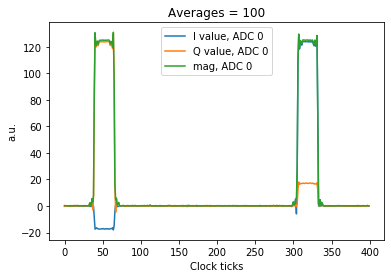

In [8]:
class DoublePulseProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        gain = cfg["pulse_gain"]

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.default_pulse_registers(ch=res_ch, style=style, freq=freq, gain=gain, 
                                         length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.default_pulse_registers(ch=res_ch, style=style, freq=freq, gain=gain, 
                                         waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.default_pulse_registers(ch=res_ch, style=style, freq=freq, gain=gain, 
                                         waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        phase1 = self.deg2reg(self.cfg["res_phase"], gen_ch=self.cfg["res_ch"])
        phase2 = self.deg2reg(self.cfg["res_phase"]+90, gen_ch=self.cfg["res_ch"])
        # fire a single trigger, but two pulses offset by 200 tProc clock ticks
        # with the first ADC trigger, pulse PMOD0_0 for a scope trigger
        # after the full sequence is set up, pause the tProc until readout is done
        # and increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.set_pulse_registers(ch=self.cfg["res_ch"], phase=phase1)
        self.pulse(ch=self.cfg["res_ch"], t=0)
        self.set_pulse_registers(ch=self.cfg["res_ch"], phase=phase2)
        self.pulse(ch=self.cfg["res_ch"], t=200)
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":400, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages
       }

prog = DoublePulseProgram(soccfg, config)
# print(prog.acquire(soc))
# print(prog.di_buf)
iq_list = prog.acquire_decimated(soc)

plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

### Send/receive a pulse with <code> pulse_style </code> = <code> flat_top </code>

In [9]:
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "flat_top", # --Fixed
        "length": 50, # [Clock ticks]
        # Try varying  length from 10-100 clock ticks
        "sigma": 30, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":300, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":5000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)


  0%|          | 0/100 [00:00<?, ?it/s]

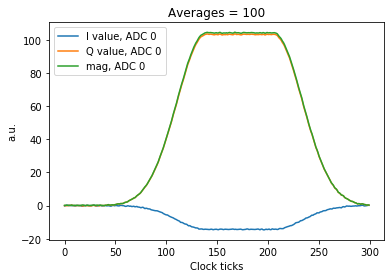

In [10]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

### Send/receive a pulse with <code> pulse_style </code> = <code> arb </code>

In [11]:
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "arb", # --Fixed
        
        "sigma": 30, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":300, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":5000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)


  0%|          | 0/100 [00:00<?, ?it/s]

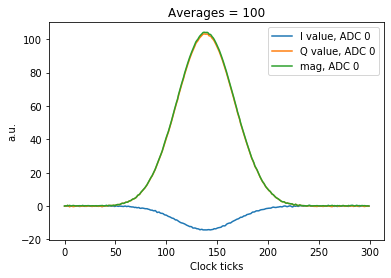

In [12]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

### Compare the two main ways of acquiring data: [`acquire_decimated()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.averager_program.html#qick.averager_program.AveragerProgram.acquire_decimated) and [`acquire()`](https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.averager_program.html#qick.averager_program.AveragerProgram.acquire)

In the previous two demonstrations we used `acquire_decimated()` which uses the QICK decimated buffer (acquiring a whole time trace of data for every measurement shot. The QICK accumulated buffer is used in `acquire()`, which acquires a single I/Q data point per measurement shot- the average of the I/Q values in the decimated buffer. In qubit experiments we will be mainly using `acquire()` since for every shot we only need one I/Q value to assess the state of the qubit. So let's verify that `acquire_decimated()` and `acquire()` produce similar results (to within +/- 1 DAC units).

In [13]:
# First, lets collect the results with the decimated buffer as we did before.
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        "length":20, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":10000, # [DAC units]
        "pulse_freq": 250, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":100
       }

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)


  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
print("I value; ADC 0; Decimated buffer: ",  np.mean(iq_list[0][0]))
print("Q value; ADC 0; Decimated buffer: ", np.mean(iq_list[0][1]))


I value; ADC 0; Decimated buffer:  -7.609349999999999
Q value; ADC 0; Decimated buffer:  55.115199999999994


In [15]:
# Now, lets collect the results with the accumulated buffer. 
config["reps"] = 100; # Set reps equal to soft_avgs in the prior acquisition method

prog =LoopbackProgram(soccfg, config)
avgi, avgq = prog.acquire(soc)

In [16]:
print("I value; ADC 0; Accumulated buffer: ", avgi[0])
print("Q value; ADC 0; Accumulated buffer: ", avgq[0])


I value; ADC 0; Accumulated buffer:  [-7.6069565]
Q value; ADC 0; Accumulated buffer:  [55.103993]


### Printing the program
It's sometimes useful to print the program in ASM format, to get a feeling for what's going on.

In [17]:
print(prog)


// Program

        regwi 4, $11, 174762666;                //freq = 174762666
        regwi 4, $12, 0;                        //phase = 0
        regwi 4, $14, 10000;                    //gain = 10000
        regwi 4, $15, 589844;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 20 
        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 99;
LOOP_J: regwi 0, $31, 16385;                    //out = 0b0100000000000001
        seti 0, 0, $31, 100;                    //ch =0 out = $31 @t = 0
        seti 0, 0, $0, 110;                     //ch =0 out = 0 @t = 0
        regwi 4, $16, 0;                        //t = 0
        set 7, 4, $11, $12, $0, $14, $15, $16;  //ch = 6, pulse @t = $16
        waiti 0, 250;
        synci 634;
        mathi 0, $15, $15 + 1;
        memwi 0, $15, 1;
        loopnz 0, $14, @LOOP_J;
        end ;
